In [19]:
# Copyright (c) 2022, Clinical ML lab
# Licensed under the BSD 3-clause license (see LICENSE.txt)

# ---------------------------------------------------------
# Unit test for synthetic data generation and baselines
# ---------------------------------------------------------

from __future__ import absolute_import, division, print_function
from matplotlib import pyplot as plt
import numpy as np
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [20]:
IN_COLAB = 'google.colab' in sys.modules

In [21]:
if IN_COLAB: 

  from google.colab import drive
  drive.mount('/content/drive/')

  %cd /content/drive/My Drive/Colab Notebooks/TCP

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/TCP


In [22]:
from data.synthetic import *
from conformal.quantiles import *
from conformal.TCP import *
from utils.visualize import *
from utils.metrics import *

In [23]:
data_params = dict({"a":-5, 
                    "b":5, 
                    "T":10, 
                    "C_1":4.5, 
                    "C_2":0, 
                    "alpha":0.1, 
                    "form":"cos",  
                    "feature_dist":"uniform"}) 

In [24]:
alpha                       = .1

n_train                     = 1000
n_calibration               = 2000
n_test                      = 1000

#X_train, Y_train, q_train = sample_data(n=n_train, **data_params)
X_calib, Y_calib, q_calib   = sample_data(n=n_calibration, **data_params)
X_test, Y_test, q_test      = sample_data(n=n_test, **data_params)

data_params["feature_dist"] = "fixed" 

X_fixed, Y_fixed, q_fixed   = sample_data(n=1000, **data_params)

## **Conformal prediction**

In [25]:
q_conformal           = empirical_quantile(Y_calib, alpha=alpha)

In [26]:
# make this efficient (run experiment script)

training_data_plot    = prepare_plot(X=X_test, Y=Y_test, type="scatter", 
                                     args=dict({"color":"white", 
                                                "edgecolors":"dimgray", 
                                                "s":5}))

tr_quant_upper_plot   = prepare_plot(X=X_fixed, Y=np.abs(q_fixed), type="plot",
                                     args=dict({"color":"blue", 
                                                   "label":"True quantile"}))

tr_quant_lower_plot   = prepare_plot(X=X_fixed, Y=-1*np.abs(q_fixed), type="plot",
                                     args=dict({"color":"blue"}))


cp_quant_upper_plot   = prepare_plot(X=X_fixed, Y=np.abs(q_conformal) * np.ones(len(X_fixed)), type="plot",
                                     args=dict({"color":"red", 
                                                "linewidth":3, 
                                                "linestyle":"--", 
                                                "label":"CP quantile"}))

cp_quant_lower_plot   = prepare_plot(X=X_fixed, Y=-1*np.abs(q_conformal) * np.ones(len(X_fixed)), type="plot",
                                     args=dict({"color":"red", 
                                                "linewidth":3, 
                                                "linestyle":"--"}))

In [27]:
plot_dict             = dict({"training data"    : training_data_plot,
                              "tr_quantile_upper": tr_quant_upper_plot,
                              "tr_quantile_lower": tr_quant_lower_plot,
                              "cp_quantile_upper": cp_quant_upper_plot,
                              "cp_quantile_lower": cp_quant_lower_plot})

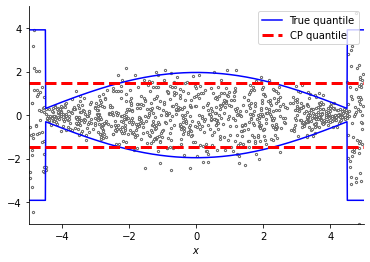

In [28]:
plotting(plot_dict, 
         legend=True, 
         xlabel="$x$",
         ylabel=None,
         legend_loc="upper right",
         xlim=(-5, 5),
         ylim=(-5, 5),
         save=False,
         filename=None)

## **Transparent conformal prediction**

In [29]:
TCP_model = TCP_RIF()

TCP_model.fit(X_calib, Y_calib)

q_TCP_RIF = TCP_model.predict(X_fixed)

In [30]:
tcp_quant_upper_plot  = prepare_plot(X=X_fixed, Y=q_TCP_RIF, type="plot",
                                     args=dict({"color":"red", 
                                                "linewidth":3, 
                                                "linestyle":"--", 
                                                "label":"TCP-RIF quantile"}))

tcp_quant_lower_plot  = prepare_plot(X=X_fixed, Y=-1*q_TCP_RIF, type="plot",
                                     args=dict({"color":"red", 
                                                "linewidth":3, 
                                                "linestyle":"--"}))

In [31]:
plot_dict.update({"tcp_quant_upper": tcp_quant_upper_plot,
                  "tcp_quant_lower": tcp_quant_lower_plot})

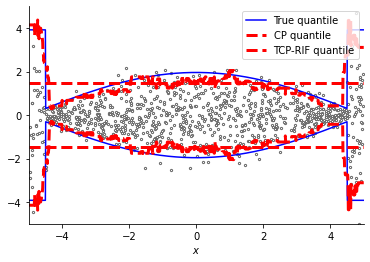

In [32]:
plotting(plot_dict, 
         legend=True, 
         xlabel="$x$",
         ylabel=None,
         legend_loc="upper right",
         xlim=(-5, 5),
         ylim=(-5, 5),
         save=False,
         filename=None)

In [32]:
# check performance with the original notebook / display relevance groups / samp